<a href="https://colab.research.google.com/github/sanmacia/ProyectoIA/blob/main/01_Predictive_Models_Airbnb_Rental_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

replicating local resources


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from local.lib import calhousing as ch

## IMPORT FROM WEBSITE

In [ ]:
! pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/ruthgn/new-orleans-airbnb-listings-and-reviews') #Colocar URL de la competición de kaggle

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: diegosaavedrav
Your Kaggle Key: ··········


100%|██████████| 40.2M/40.2M [00:00<00:00, 44.9MB/s]


In [ ]:
li = pd.read_csv('/content/new-orleans-airbnb-listings-and-reviews/new_orleans_airbnb_listings.csv')
re = pd.read_csv('/content/new-orleans-airbnb-listings-and-reviews/new_orleans_airbnb_reviews.csv')

## DATA CLEANING

### Inspección

In [ ]:
li.info()

In [ ]:
li.head()

In [ ]:
re.head()

### Variables categóricas

In [ ]:
#Valores unicos categóricos
ccols = [i for i in li.columns if not i in li._get_numeric_data()]
for c in ccols:
    print ("%10s"%c, np.unique(li[c].dropna()))

In [ ]:
#------------------------------Borrar columnas innecesaria------------------------
li = li.drop(['id', 'name', 'description', 'neighborhood_overview',
              'host_since', 'host_location', 'host_verifications','host_has_profile_pic',
              'host_neighbourhood','host_identity_verified','first_review',
              'last_review', 'license', ], axis=1)


#--------------------------------Separar variable bathrooms_text----------------------
li[['bathrooms','bathrooms_type', 'x']] = li['bathrooms_text'].str.split(' ',expand=True) #Separar variable
li['bathrooms'] = li['bathrooms'].astype('float') #Convertir a flotante
li = li.drop(['x', 'bathrooms_text'], axis=1) #Borrar columnas innecesarias
li['bathrooms_type'] = li['bathrooms_type'].replace({'bath' : 'entire home/apt', 'baths' : 'entire home/apt'}) #Reemplazar bath y baths por entire



#-----------------------------Corregir variable price------------------------------
li["price"] = li["price"].apply(lambda x: x.replace("$","")) #Quitar el signo ($) 
li["price"] = li["price"].apply(lambda x: x.replace(",","")) #Quitar las comas (,)
li['price'] = li['price'].astype('float') #Convertir a flotante

#-----------------------------Corregir variable host acceptance rate------------------------------
li["host_acceptance_rate"] = li["host_acceptance_rate"].apply(lambda x: str(x).replace("%","")) #Quitar el signo (%) 
li['host_acceptance_rate'] = li['host_acceptance_rate'].astype('float') #Convertir a flotante

#-----------------------------Corregir variable host response rate------------------------------
li["host_response_rate"] = li["host_response_rate"].apply(lambda x: str(x).replace("%","")) #Quitar el signo (%) 
li['host_response_rate'] = li['host_response_rate'].astype('float') #Convertir a flotante




li["instant_bookable"] = li["instant_bookable"].replace({'t': 1, 'f': 0})
li["host_is_superhost"] = li["host_is_superhost"].replace({'t': 1, 'f': 0})
li["has_availability"] = li["has_availability"].replace({'t': 1, 'f': 0})


#--------------------------Renombrar columna----------------------
li = li.rename(columns={'review_scores_rating':'global_score',
                        'neighbourhood_cleansed' : 'neighborhood'})


#-----------------------Seleccionar columnas relevantes------------------
li = li.loc[:,['neighborhood', 'property_type','room_type', 
        'accommodates', 'bathrooms', 'bathrooms_type', 'bedrooms', 'beds',
       'amenities', 'minimum_nights', 'maximum_nights',
       'host_id', 'host_is_superhost', 'host_listings_count',
       'host_response_time','host_response_rate', 'host_acceptance_rate',
       'instant_bookable' , 'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 
       'global_score', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','reviews_per_month','latitude', 'longitude', 'price']] #Deja las columnas mencionadas y en ese orden y las que no están las elimlina

In [ ]:
li['bathrooms'].unique()

In [ ]:
li['bathrooms_type'].value_counts()

In [ ]:
#Filtro que contenga la palabra Entire
li[li['bathrooms_type'].str.contains('entire', na = True)].sample(5) 

In [ ]:
#Valores unicos categóricos
ccols = [i for i in li.columns if not i in li._get_numeric_data()]
for c in ccols:
    print ("%10s"%c, np.unique(li[c].dropna()))

### Variables continuas

In [ ]:
#Valores únicos continuos
ccols = [i for i in li.columns if i in li._get_numeric_data()]
for c in ccols:
    print ("%10s"%c, np.unique(li[c].dropna()))

### Limpieza nulos

In [ ]:
#Totalidad de nulos en las variables
k = li.isna().sum()
print('Antes de eliminar nulos')
print('###########################') 
print(k[k!=0])
#---------------------------------------Reemplazar nan por palabras---------------------------
li['bathrooms_type'] = li['bathrooms_type'].replace({np.nan : 'no baths'})


#--------------------------------------------Reemplazar nan por ceros----------------------------------------------
li[['bedrooms', 'beds', 'bathrooms', 'reviews_per_month', 'host_listings_count']] = li[['bedrooms', 'beds','bathrooms', 'reviews_per_month', 'host_listings_count']].fillna(0)




#-------------------Rellenar nulos del puntaje global con el promedio de ese anfitrión----------------------------- 
li['host_response_rate'] = li.groupby(['host_id'])  ['host_response_rate'].apply(lambda x: x.fillna(x.mean()))
li['host_acceptance_rate'] = li.groupby(['host_id'])  ['host_acceptance_rate'].apply(lambda x: x.fillna(x.mean()))

#-----------------------Rellenar nulos del puntaje global con el promedio de ese anfitrión---------------------------- 
li['global_score'] = round(li.groupby(['host_id'])  ['global_score'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_accuracy'] = round(li.groupby(['host_id'])  ['review_scores_accuracy'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_cleanliness'] = round(li.groupby(['host_id'])  ['review_scores_cleanliness'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_checkin'] = round(li.groupby(['host_id'])  ['review_scores_checkin'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_communication'] = round(li.groupby(['host_id'])  ['review_scores_communication'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_location'] = round(li.groupby(['host_id'])  ['review_scores_location'].apply(lambda x: x.fillna(x.mean())), 2)
li['review_scores_value'] = round(li.groupby(['host_id'])  ['review_scores_value'].apply(lambda x: x.fillna(x.mean())), 2)



li = li.drop(['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_id'], axis=1) #Borrar columnas innecesarias

li = li.dropna() #Borrar registros que tengan nan


#Convertir columnas a entero
li[['bedrooms', 'beds', 'price', 'reviews_per_month', 'host_listings_count']] = li[['bedrooms', 'beds', 'price', 'reviews_per_month', 'host_listings_count']].astype('int64') 


#Eliminar 2 registros que tienen price = 0
li = li.drop(li[li['price'] == 0].index)


#Totalidad de nulos en las variables
k = li.isna().sum()
print('')

print('Después de eliminar nulos')
print('###########################') 
print(k[k!=0])

Antes de eliminar nulos
###########################
bathrooms                        16
bathrooms_type                   16
bedrooms                        303
beds                            122
host_is_superhost                38
host_listings_count              38
host_response_time             1579
host_response_rate             1579
host_acceptance_rate           1466
global_score                    672
review_scores_accuracy          687
review_scores_cleanliness       685
review_scores_checkin           687
review_scores_communication     686
review_scores_location          687
review_scores_value             687
reviews_per_month               672
dtype: int64

Después de eliminar nulos
###########################
Series([], dtype: int64)


In [ ]:
li.info()

## DATA EXPLORATION

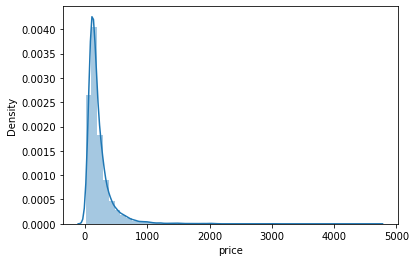

In [ ]:
#Inspect the target variable
import seaborn as sns
sns.distplot(li['price'])

In [ ]:
li['price'].describe()

count    5731.000000
mean      222.500262
std       226.942615
min        11.000000
25%       104.000000
50%       156.000000
75%       258.000000
max      4657.000000
Name: price, dtype: float64

### Mapa de calor

In [ ]:
from bokeh.plotting import *
#from bokeh.charts import *
from bokeh.models import *
import bokeh
from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler

def latlng_to_meters(lat, lng):
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lng * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    return mx, my


def xplot_map(lat, lon, color=None, size=10):
    cmap = cm.rainbow
    wlat, wlong = latlng_to_meters(lat, lon)
    if color is not None:
        colors = MinMaxScaler(feature_range=(0,255)).fit_transform(color)
        colors = ["#%02x%02x%02x"%tuple([int(j*255) for j in cmap(int(i))[:3]]) for i in colors]

    openmap_url = 'http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'
    otile_url = 'http://otile1.mqcdn.com/tiles/1.0.0/sat/{Z}/{X}/{Y}.jpg'

    TILES = WMTSTileSource(url=openmap_url)
    tools="pan,wheel_zoom,reset"
    p = figure(tools=tools, plot_width=700,plot_height=600)

    p.add_tile(TILES)

    p.axis.visible = False

    cb = figure(plot_width=40, plot_height=600,  tools=tools)
    yc = np.linspace(np.min(color),np.max(color),20)
    c = np.linspace(0,255,20).astype(int)
    dy = yc[1]-yc[0]
    cb.rect(x=0.5, y=yc, color=["#%02x%02x%02x"%tuple([int(j*255) for j in cmap(int(i))[:3]]) for i in c], width=1, height = dy)
    cb.xaxis.visible = False
    p.circle(np.array(wlat), np.array(wlong), color=colors, size=size)
    pb = gridplot([[p, cb]])
    show(pb)

In [ ]:
ds = li.sample(500)
xplot_map(ds["latitude"].values, 
         ds["longitude"].values, ds["price"].values.reshape(-1,1)/1e5)

### Correlación

In [ ]:
#correlation matrix
corrmat = li.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## DATA PREPROCESSING

Se deben transformar los datos categoricos y numericos

* Categoricos: Nominal o ordinal
* Numericos: Estandarizar datos

In [ ]:
#-------------------------------------Debido a su gran cantidad de categorias se eliminan estas columnas--------------
li = li.drop(['property_type', 'amenities'], axis=1)

In [ ]:
#############################################Codificar variables categoricas#########################################

df = li.copy()

from sklearn.preprocessing import OrdinalEncoder

enc_cat = OrdinalEncoder()
df[['neighborhood', 'room_type', 'bathrooms_type']] = enc_cat.fit_transform(df[['neighborhood', 'room_type', 'bathrooms_type']])

In [ ]:
#############################################Codificar variables numericas#########################################



#from sklearn.preprocessing import StandardScaler
#enc_num = StandardScaler() 

#Se deben poner las columnas en doble [[]] al principio y al final
#df[['latitude', 'longitude', 'price']] = enc_num.fit_transform(df[['latitude', 'longitude', 'price']]) 

## MODEL EVALUATION

### Separate variable to predict

In [ ]:
######################################################### Selección de train test####################################################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import cross_validate, ShuffleSplit

#------------------------Parameters-----------------------------------------------------------------------------------------------------------------------
target = 'price'
test_size = 0.3 #Porcentaje del tamaño del test final para medir desempeño (test = 10%, train = 90%) 
number_of_houses_for_trainval = 250 # (5% del dataset) Numero de datos de una muestra aleatoria del dataset para train [Valores más grandes pueden producir un mejor desempeño]
df = df #Dataset
mitad = round((len(df) / 2)) #Mitad del dataset
#-----------------------------------------------------------------------------------------------------------------------------------------------


val_size  = test_size/(1-test_size) 

assert number_of_houses_for_trainval< mitad, "too many houses for trainval"


d = df.iloc[: mitad].sample(number_of_houses_for_trainval)
X = d.values[:,:-1]
y = d[target].values
print (X.shape, y.shape)

print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)


#----------------------------------------------------------Métricas de desempeño------------------------------------------------------------
def rel_mrae(estimator, X, y): 
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

#Reporte del score
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))


(250, 30) (250,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(175, 30) (75, 30)


### MODELS

#### MODEL 1 DecisionTreeRegressor (5)

test score   0.565 (±0.2021) with 10 splits
train score  0.332 (±0.0207) with 10 splits


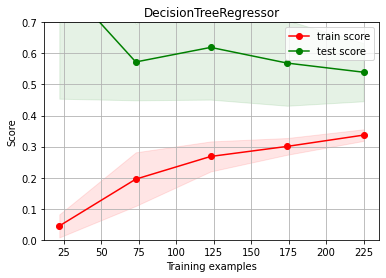

In [ ]:
from sklearn.tree import DecisionTreeRegressor
estimator1 = DecisionTreeRegressor(max_depth=5) #Cambiar [estimador y argumento del modelo]

cv=ShuffleSplit(n_splits=10, test_size=0.1)
z1 = cross_validate(estimator1, X, y, return_train_score=True, return_estimator=True, #Cambiar [z, estimador]
                    scoring=rel_mrae, cv = cv)
report_cv_score(z1)                                                                     #Cambiar z

ch.plot_learning_curve(estimator1, estimator1.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7)) #Cambiar [estimador]

Vemos un caso de sesgo, entonce tenemos dos soluciones:
* Aumentar la complejidad del modelo 
* Conseguir más columnas


#### MODEL 2 DecisionTreeRegressor (10)

test score   0.543 (±0.0942) with 10 splits
train score  0.068 (±0.0151) with 10 splits


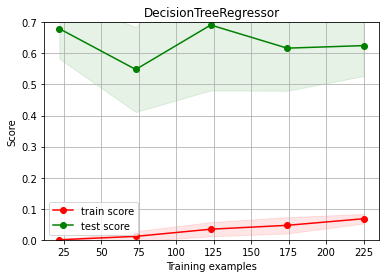

In [ ]:
from sklearn.ensemble import RandomForestRegressor
estimator2 = DecisionTreeRegressor(max_depth=10) #Cambiar [estimador y argumento del modelo]


cv=ShuffleSplit(n_splits=10, test_size=0.1)
z2 = cross_validate(estimator2, X, y, return_train_score=True, return_estimator=True, #Cambiar [z, estimador]
                    scoring=rel_mrae, cv=cv)  
report_cv_score(z2)                                                                     #Cambiar [z]

ch.plot_learning_curve(estimator2, estimator2.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7)) #Cambiar [estimador]

#### MODEL 3 SVC (gamma = 0.00001)

test score   0.478 (±0.0620) with 10 splits
train score  0.438 (±0.0263) with 10 splits


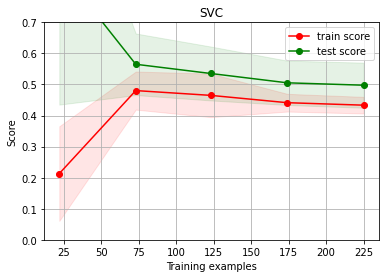

In [ ]:
from sklearn.svm import SVC

estimador3 = SVC(gamma= 0.00001) #Cambiar [estimador]

cv=ShuffleSplit(n_splits=10, test_size=0.1)
z3 = cross_validate(estimador3, X, y, return_train_score=True, return_estimator=True, #Cambiar [z, estimador]
                    scoring=rel_mrae, cv=cv)
report_cv_score(z3)                                                                     #Cambiar [z]

ch.plot_learning_curve(estimador3, estimador3.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7)) #Cambiar [estimador]

#### Model 4 SVC (gamma = 0.001)

test score   0.477 (±0.0395) with 10 splits
train score  0.056 (±0.0078) with 10 splits


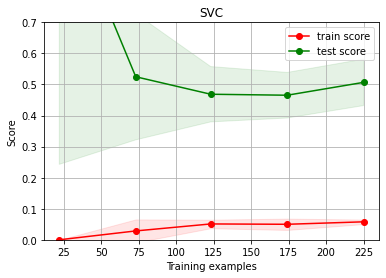

In [ ]:
from sklearn.svm import SVC

estimador4 = SVC(gamma= 0.001) #Cambiar [estimador]

cv=ShuffleSplit(n_splits=10, test_size=0.1)
z4 = cross_validate(estimador4, X, y, return_train_score=True, return_estimator=True, #Cambiar [z, estimador]
                    scoring=rel_mrae, cv=cv)
report_cv_score(z4)                                                                     #Cambiar [z]

ch.plot_learning_curve(estimador4, estimador4.__class__.__name__, X, y, cv=cv, scoring=rel_mrae, ylim=(0,0.7)) #Cambiar [estimador]

## MODEL SELECTION

In [ ]:
#################################################Selección de mejor modelo#####################################
zscores = []
estimators = [estimator1, estimator2, estimador3, estimador4 ] #Cambiar estimadores []


for estimator in estimators:
    print("--")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))
best = np.argmin(zscores)
#print ("selecting ", best)
best_estimator = estimators[best]
print ("\nselected model", best +1 )
print (best_estimator)

print('')
print('##########################################Real data test################################################')
print('')
print('')
best_estimator.fit(Xtv,ytv)
reported_performance = rel_mrae(best_estimator, Xts, yts)
print ("reported performance of selectd model %.3f"%reported_performance, '| Name final model:',best_estimator)

--
test score   0.531 (±0.0757) with 10 splits
train score  0.231 (±0.0311) with 10 splits
--
test score   0.672 (±0.1213) with 10 splits
train score  0.026 (±0.0180) with 10 splits
--
test score   0.494 (±0.0353) with 10 splits
train score  0.438 (±0.0337) with 10 splits
--
test score   0.542 (±0.0730) with 10 splits
train score  0.034 (±0.0271) with 10 splits

selected model 3
SVC(gamma=1e-05)

##########################################Real data test################################################


reported performance of selectd model 0.462 | Name final model: SVC(gamma=1e-05)
